In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from collections import Counter
from googletrans import Translator
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
from nltk import pos_tag

data = pd.read_csv('../data/amazon_reviews.csv')

In [5]:
print(data.head())

   Unnamed: 0  score                                             review
0           0      1   Stuning even for the non-gamer: This sound tr...
1           1      1   The best soundtrack ever to anything.: I'm re...
2           2      1   Amazing!: This soundtrack is my favorite musi...
3           3      1   Excellent Soundtrack: I truly like this sound...
4           4      1   Remember, Pull Your Jaw Off The Floor After H...


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [10]:
# Detect language distribution - identifies the language of each review and visualizes
def plot_language_distribution(df, review_column='review'):
    """
    Detects language of each review and plots a frequency chart.
    """
    # Detect language for each review
    df['language'] = df[review_column].apply(lambda x: detect(x) if pd.notnull(x) else 'unknown')

    # Count frequency of each language
    language_counts = df['language'].value_counts()

    # Create bar chart
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')

    # Add count labels above bars
    for i, value in enumerate(language_counts.values):
        ax.text(i, value + max(language_counts.values)*0.01, str(value),
                ha='center', va='bottom', fontweight='bold')

    plt.title('Language Frequency in Amazon Reviews')
    plt.xlabel('Language Code')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return language_counts

C:\Users\alexandra\AppData\Local\Temp\ipykernel_17412\2331761390.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=language_counts.index, y=language_counts.values, palette='muted')


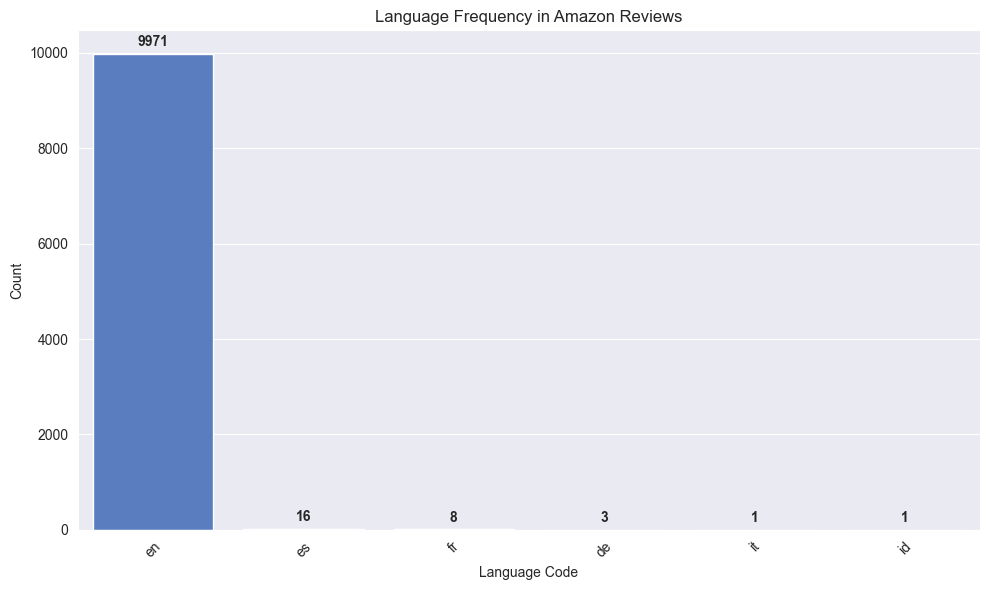

In [11]:
language_distribution_amazon = plot_language_distribution(data)

In [14]:
# Translate non-English reviews to English - ensures all reviews are in the same language
from deep_translator import GoogleTranslator

def detect_and_translate(text):
    """
    Detects language and translates to English if needed.
    Uses deep_translator which is more stable than googletrans.
    """
    try:
        if pd.isnull(text):
            return ""

        lang = detect(text)
        if lang != 'en':
            # Using deep_translator instead
            translator = GoogleTranslator(source=lang, target='en')
            translation = translator.translate(text)
            return translation
        return text
    except Exception as e:
        print(f"Translation error: {e}")
        return text

In [15]:
data['translated_review'] = data['review'].apply(detect_and_translate)

In [21]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [18]:
import nltk
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocesses text: lowercase, remove punctuation/numbers, tokenize, remove stopwords.
    """
    if pd.isnull(text):
        return ""

    text = str(text).lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
data['cleaned_review'] = data['translated_review'].apply(preprocess_text)

In [23]:
print(data.head())

   Unnamed: 0  score                                             review  \
0           0      1   Stuning even for the non-gamer: This sound tr...   
1           1      1   The best soundtrack ever to anything.: I'm re...   
2           2      1   Amazing!: This soundtrack is my favorite musi...   
3           3      1   Excellent Soundtrack: I truly like this sound...   
4           4      1   Remember, Pull Your Jaw Off The Floor After H...   

  language                                  translated_review  \
0       en   Stuning even for the non-gamer: This sound tr...   
1       en   The best soundtrack ever to anything.: I'm re...   
2       en   Amazing!: This soundtrack is my favorite musi...   
3       en   Excellent Soundtrack: I truly like this sound...   
4       en   Remember, Pull Your Jaw Off The Floor After H...   

                                      cleaned_review  
0  stuning even nongamer sound track beautiful pa...  
1  best soundtrack ever anything im reading lot 

In [24]:
# Sentiment analysis - determines if reviews are positive, negative or neutral
def get_sentiment(text):
    """
    Analyzes sentiment of text using TextBlob (-1 to +1 score).
    """
    if pd.isnull(text) or text == "":
        return 0

    blob = TextBlob(text)
    return blob.sentiment.polarity

In [25]:
data['sentiment_score'] = data['cleaned_review'].apply(get_sentiment)
data['sentiment_label'] = data['sentiment_score'].apply(
    lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral'
)

In [26]:
# Display sentiment distribution
sentiment_counts = data['sentiment_label'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_counts)


Sentiment Distribution:
sentiment_label
positive    7344
negative    2465
neutral      191
Name: count, dtype: int64


In [27]:
neutral_reviews = data[data['sentiment_label'] == 'neutral']
print(f"\nTotal neutral reviews: {len(neutral_reviews)}")


Total neutral reviews: 191


In [28]:
# Extract emotional words and create wordclouds - visualizes key emotional language
def extract_emotional_words(text):
    """
    Extracts emotional words (adjectives and adverbs) from text.
    """
    if pd.isnull(text) or text == "":
        return ""

    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Only adjectives and adverbs (JJ, JJR, JJS, RB, RBR, RBS)
    emotional_words = [word for word, tag in pos_tags if tag.startswith('JJ') or tag.startswith('RB')]
    return ' '.join(emotional_words)

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds(df, text_column='cleaned_review', sentiment_column='sentiment_label'):
    """
    Creates wordclouds showing emotional words for each sentiment category.
    """
    sentiments = ['positive', 'neutral', 'negative']
    colors = ['Greens', 'Blues', 'Reds']

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))

    for i, sentiment in enumerate(sentiments):
        subset = df[df[sentiment_column] == sentiment]
        emotional_text = ' '.join(subset[text_column].dropna().apply(extract_emotional_words))

        if emotional_text.strip():  # Only generate if text exists
            wordcloud = WordCloud(width=800, height=400, background_color='white',
                                 colormap=colors[i]).generate(emotional_text)

            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].set_title(f'{sentiment.capitalize()} Reviews (Emotional Language)', fontsize=18)
        else:
            axes[i].text(0.5, 0.5, f"No {sentiment} reviews with emotional words",
                       ha='center', va='center', fontsize=14)

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [31]:
nltk.download('averaged_perceptron_tagger_eng')

# Extract emotional words
data['emotional_words'] = data['cleaned_review'].apply(extract_emotional_words)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\alexandra\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


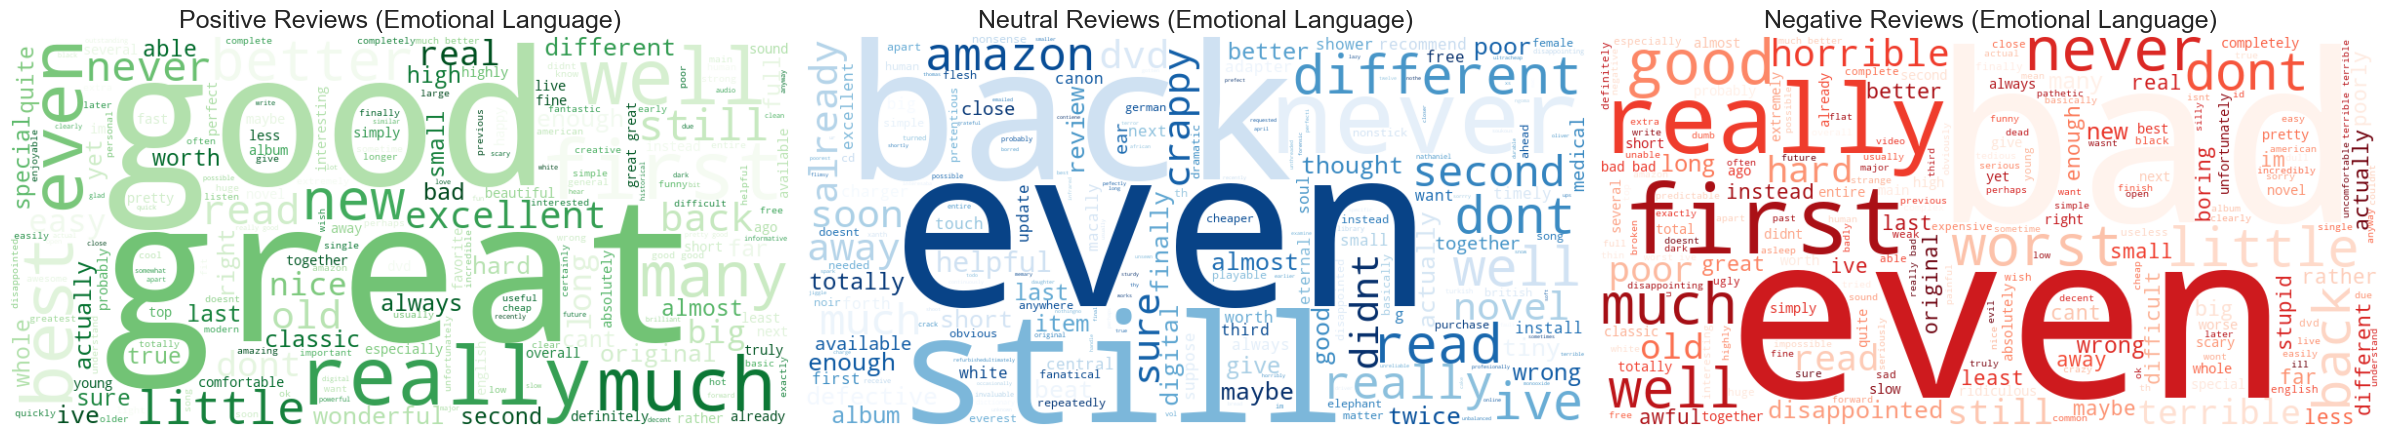

In [32]:
# Create wordclouds
plot_wordclouds(data)

In [35]:
print("Unique values in 'score' column:", sorted(data['score'].unique()))

Unique values in 'score' column: [np.int64(0), np.int64(1)]


In [36]:
# Map the binary score values to sentiment categories
binary_mapping = {
    0: 'negative',
    1: 'positive'
}

# Apply mapping to create original_sentiment column
data['original_sentiment'] = data['score'].map(binary_mapping)

# Create comparison between TextBlob sentiment and original ratings
comparison = pd.crosstab(data['sentiment_label'],
                       data['original_sentiment'],
                       normalize='index')
print("\nComparison between TextBlob sentiment and original ratings:")
print(comparison)

# Optional: Calculate accuracy
if 'original_sentiment' in data.columns and 'sentiment_label' in data.columns:
    # Calculate how often TextBlob sentiment matches original sentiment
    matches = (data['original_sentiment'] == data['sentiment_label']).sum()
    total = len(data)
    accuracy = matches / total
    print(f"\nTextBlob sentiment accuracy: {accuracy:.2%} ({matches} correct out of {total})")


Comparison between TextBlob sentiment and original ratings:
original_sentiment  negative  positive
sentiment_label                       
negative            0.895335  0.104665
neutral             0.696335  0.303665
positive            0.375408  0.624592

TextBlob sentiment accuracy: 67.94% (6794 correct out of 10000)


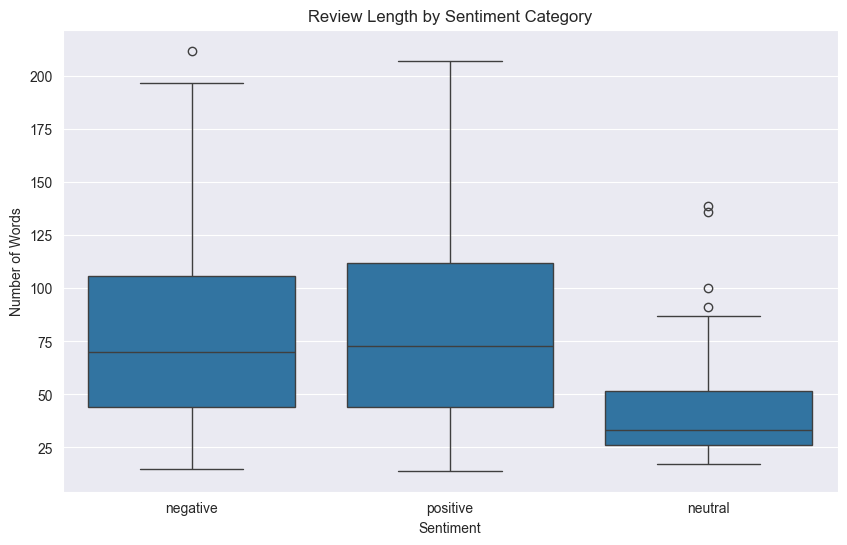

In [37]:
# Distribution of review length by detected sentiment - shows if positive/negative reviews tend to be longer
plt.figure(figsize=(10, 6))
data['review_length'] = data['review'].apply(lambda x: len(str(x).split()))
sns.boxplot(x='sentiment_label', y='review_length', data=data)
plt.title('Review Length by Sentiment Category')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.show()

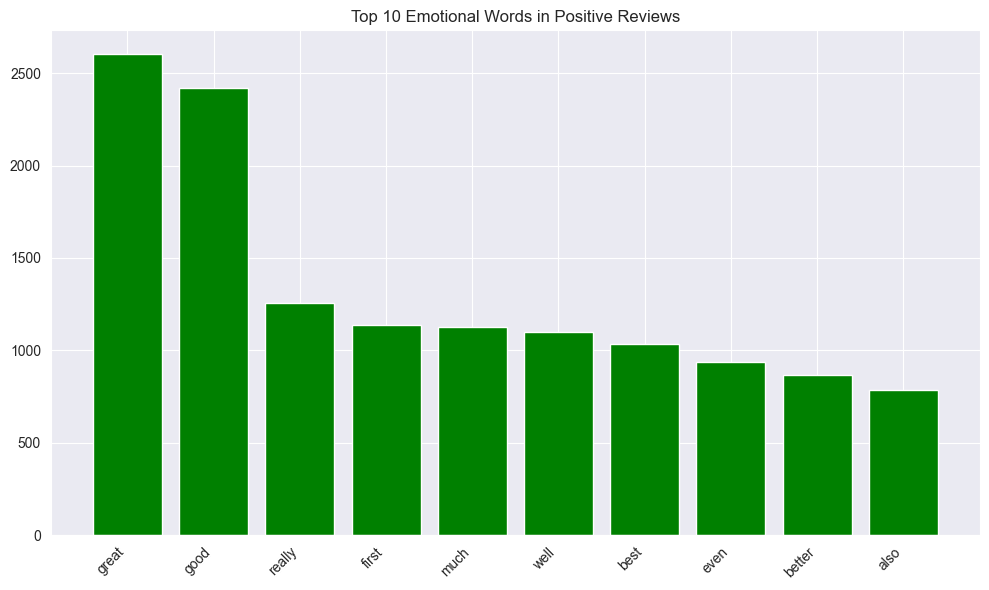

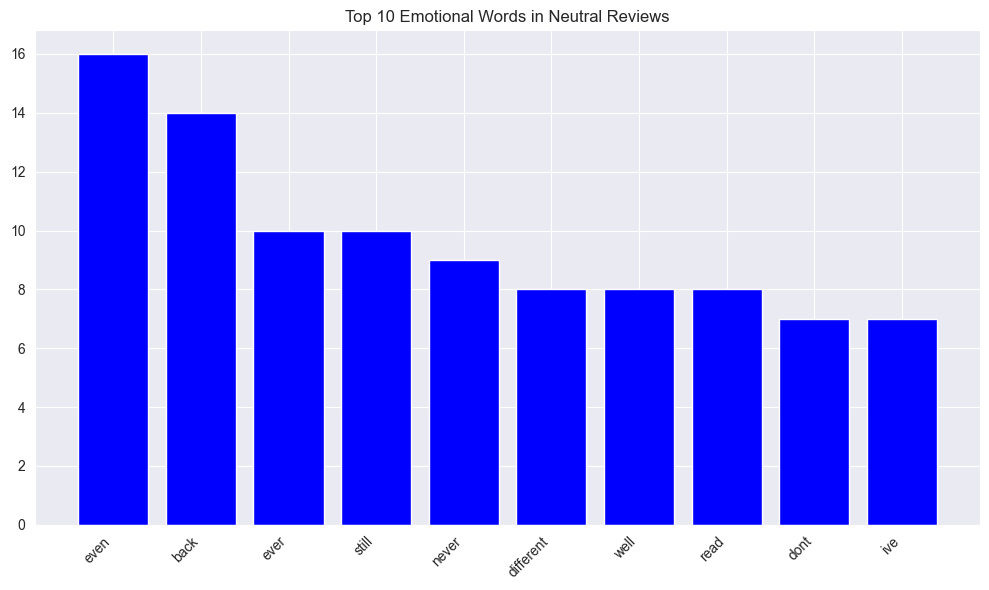

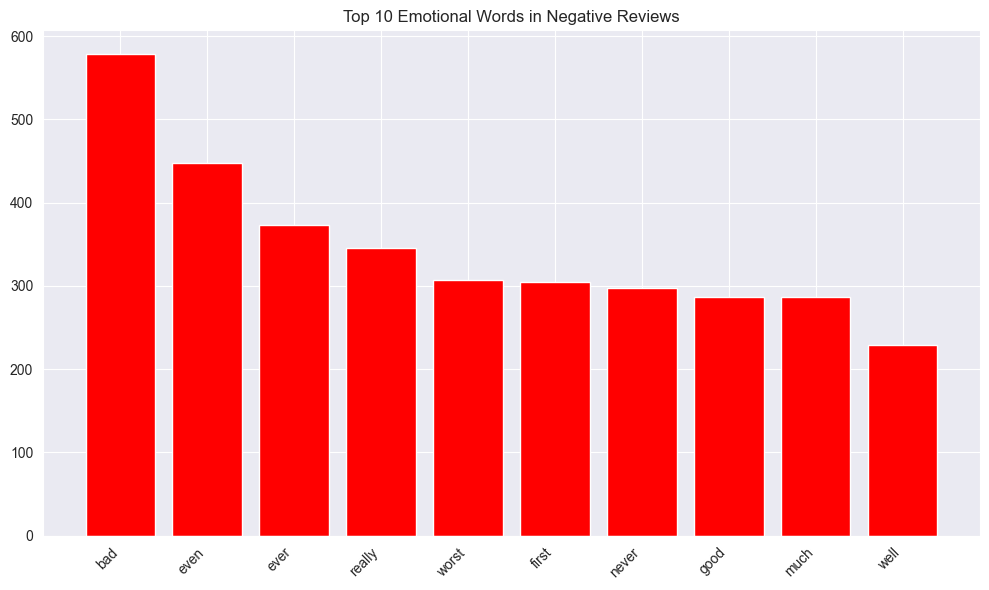

In [38]:
# Most frequent emotional words for each sentiment category - reveals key emotional language
from collections import Counter
import matplotlib.pyplot as plt

def plot_top_words(sentiment_type, n=10):
    # Filter reviews with the specified sentiment
    subset = data[data['sentiment_label'] == sentiment_type]

    # Get all emotional words from this category
    all_words = ' '.join(subset['emotional_words'].dropna()).split()

    # Count word frequency
    word_counts = Counter(all_words)

    # Extract the most frequent n words
    top_words = dict(word_counts.most_common(n))

    # Plot the results
    plt.figure(figsize=(10, 6))
    colors = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}
    plt.bar(top_words.keys(), top_words.values(), color=colors.get(sentiment_type, 'gray'))
    plt.title(f'Top {n} Emotional Words in {sentiment_type.capitalize()} Reviews')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot for each sentiment category
for sentiment in ['positive', 'neutral', 'negative']:
    if len(data[data['sentiment_label'] == sentiment]) > 0:
        plot_top_words(sentiment)
